In [1]:
import pyoti.sparse as oti
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern Roman",
    "font.size": 12,
    "font.sans-serif": ["Helvetica"]
})

In [2]:
def fun1(x,a):
    f = oti.zeros((1,1))
    f[0,0] = oti.cos(x*a) - x / a
    return f

def fun2(X,r,m,b):
    #INTERSECTION BETWEEN CURVES.
    f = oti.zeros((2,1))
    x = X[0,0].copy()
    y = X[1,0].copy()
    f[0,0] = x**2 + y**2 - r**2 
    f[1,0] = y - ( m * x + b )
    return f

def fun2_curves(x,r,m,b):
    #CURVES.
    y = oti.zeros((3,1))
    y[0,0] =  oti.sqrt(r**2 - x**2)
    y[1,0] = -oti.sqrt(r**2 - x**2)
    y[2,0] = m * x + b
    return y

In [3]:
# utils
def newton_otisis(func, jaco, x, tol, maxiter=50, args=()):
    error = 1e30
    n = 0
    nx = x.shape[0]
    dx = oti.zeros( (nx,1), order=x.order)
    argv = (func,)+args
    while error > tol:
        if n==maxiter:
            print("Did not converge. ", maxiter, "iters.")
            break
        mJ = -jaco(x,*argv)
#         print(mJ.shape)
        f_eval = func(x,*args)
#         print(f_eval.shape)
        dx = oti.dot(oti.inv(mJ),f_eval)
        error = oti.norm(dx).get_deriv(0)        
        x += dx
        n += 1
#     print("niter: ",n)
#     print("rel_err:",(oti.norm(dx)/oti.norm(x)).get_deriv(0))
    return x

def j_DF (x, *arg2):
    h = 1e-8
    nx = x.shape[0]
    J = oti.zeros((nx,nx), order=x.order)
    for i in range(nx):
        xh = x.copy()
        xh[i,0]+= h
        dfdxi = (func(xh,*args) - func(x,*args))/h
        for j in range(nx):
            J[j,i] = dfdxi[j,0]
    return J

def j_oti (x, *argv):
    nx = x.shape[0]
    func = argv[0]
    args = argv[1:]
    active_bases = func(x,*args).get_active_bases()
    if len(active_bases)==0:
        next_base = 1 
    else:
        next_base = max(active_bases) + 1
    # end if 
    e_x = oti.zeros((nx,1), order=x.order)
    for i in range(nx):
        e_x[i] = oti.e(next_base + i)  
    # end for 
    J = oti.zeros((nx,nx), order=x.order)
    fun = func(x+e_x, *args) 
    for n in range(nx):
        J_col = fun.extract_deriv(next_base + n)
        for j in range(nx):
            J_col = J_col.truncate(next_base + j)
        # end for 
        for m in range(nx):
            J[m,n] = J_col[m,0]
        # end for 
    # end for 
    return J

In [4]:
x0 = oti.array([.2])
a=5+oti.e(1, order = 2)
x = newton_otisis(fun1,j_oti,x0,1e-8, args = (a,))

In [5]:
x.real

array([[0.30206914]])

In [6]:
fun1(x,a).real

array([[-1.5959456e-16]])

In [7]:
# ROM a = 1, ∆a = -4
anew = 1
Δa = anew - a.real
xrom1 = x.rom_eval([1],[Δa])
print(xrom1)

print("Evaluating function at new value found:")
fun1(xrom1,anew)

# Solution: 0.73908513

matso< shape: (1, 1), 
 - Column 0
(0,0) 0.682281
>
Evaluating function at new value found:


matso< shape: (1, 1), 
 - Column 0
(0,0) 0.0938546
>

In [8]:
# ROM a = 2, ∆a = -3
anew = 2
Δa = anew - a.real
xrom1 = x.rom_eval([1],[Δa])
print(xrom1)

print("Evaluating function at new value found:")
fun1(xrom1,anew)

# Solution: 0.73908513

matso< shape: (1, 1), 
 - Column 0
(0,0) 0.557757
>
Evaluating function at new value found:


matso< shape: (1, 1), 
 - Column 0
(0,0) 0.160836
>

<IPython.core.display.Javascript object>


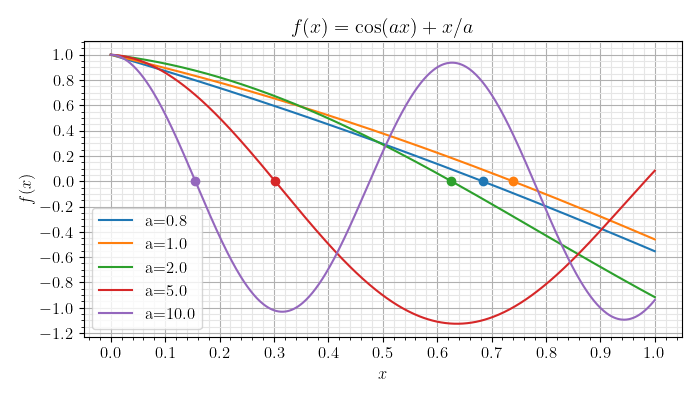

In [13]:
a_vec = [0.8,1,2,5,10]
x_vec = np.linspace(0,1.0,500)
f_vec = np.zeros((len(a_vec),x_vec.size))

plt.figure(figsize=(7,4))
i=0
x = oti.zeros((1,1))
x0 = oti.array([.2])
for a in a_vec:
    j = 0
    for xj in x_vec:
        x[0,0] = x_vec[j]
        f_eval = fun1(x,a)
        f_vec[i,j] = f_eval[0,0].real
        j+=1        
    # end for 
    ap = a+oti.e(1)
    x_root = newton_otisis(fun1,j_oti,x0,1e-6, args = (ap,))
    f_root = fun1(x_root,ap)
    plt.plot(x_root[0,0].real,f_root[0,0].real,'o'+'C'+str(i),lw=1.5)#,label="a={0:.1f}".format(a))
    plt.plot(x_vec,f_vec[i,:],'C'+str(i),lw=1.5,label="a={0:.1f}".format(a))
    i += 1
# end for

plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.title("$f(x)=\cos(ax)+x/a$")
plt.legend()
plt.grid()
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(0.1))
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.2))
plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.02))
plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(0.05))

plt.grid(which='minor', color=(0.9,0.9,0.9))
plt.tight_layout()

plt.savefig('png/fun1_cos.png',dpi=150)
plt.savefig('pdf/fun1_cos.pdf',dpi=150)
plt.show()

In [16]:
# Plot x vs a
# a_vec = np.linspace(1,5,100)
a_vec = np.linspace(.1,10,100)
x_vec = np.zeros_like(a_vec)

x0 = oti.array([.2])
i=0
for a in a_vec:
    ap = a+oti.e(1)
    x = newton_otisis(fun1,j_oti,x0,1e-6, args = (ap,))
    x_vec[i] = x[0,0].real
    i+=1

In [17]:
x_vec

array([0.099995  , 0.19984028, 0.29879554, 0.39501715, 0.48534936,
       0.5657614 , 0.63250317, 0.6833906 , 0.71836292, 0.73908513,
       0.74809987, 0.7480874 , 0.7414429 , 0.73012161, 0.71563643,
       0.69911969, 0.68140032, 0.66307535, 0.64456863, 0.62617662,
       0.6081028 , 0.59048323, 0.57340526, 0.55692129, 0.54105868,
       0.5258271 , 0.51122378, 0.49723738, 0.48385079, 0.47104317,
       0.45879143, 0.44707126, 0.43585791, 0.42512674, 0.41485355,
       0.40501486, 0.39558808, 0.38655157, 0.37788475, 0.36956809,
       0.36158308, 0.35391225, 0.34653915, 0.33944824, 0.33262493,
       0.32605548, 0.31972697, 0.31362724, 0.30774488, 0.30206914,
       0.29658992, 0.29129773, 0.28618361, 0.28123915, 0.27645642,
       0.27182795, 0.2673467 , 0.26300602, 0.25879964, 0.25472166,
       0.25076647, 0.2469288 , 0.24320365, 0.23958628, 0.23607224,
       0.23265726, 0.22933734, 0.22610867, 0.22296762, 0.21991076,
       0.21693484, 0.21403675, 0.21121355, 0.20846243, 0.20578

<IPython.core.display.Javascript object>


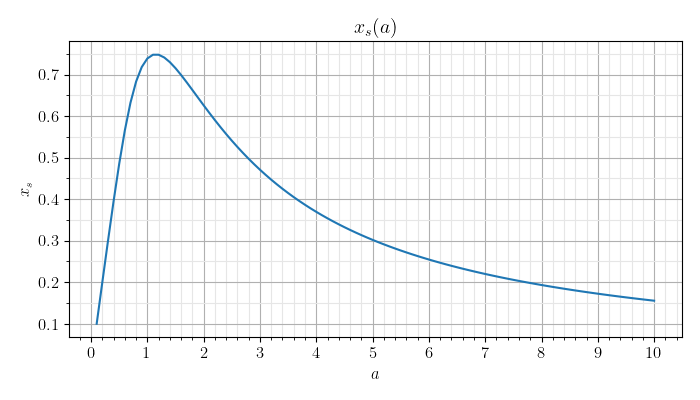

In [26]:
plt.figure(figsize=(7,4))
plt.plot(a_vec,x_vec,'C0',lw=1.5)
plt.xlabel("$a$")
plt.ylabel("$x_{s}$")
plt.title("$x_{s}(a)$")
plt.grid()
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.1))
plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.2))
plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
plt.grid(which='minor',color=(0.9,0.9,0.9))
plt.tight_layout()
plt.savefig('png/root_fun1_cos.png',dpi=150)
plt.savefig('pdf/root_fun1_cos.pdf',dpi=150)
plt.show()

In [81]:
orders = [1,2,3,5,10,30,50]
Δa_vec = np.zeros((len(orders),a_vec.size))
rom_vec = np.zeros((len(orders),a_vec.size))

ordi = 0

for order in orders:
    
    x0 = oti.array([.2])
    
    a = 10 + oti.e(1, order = order)
    x = newton_otisis(fun1,j_oti,x0,1e-6, args = (a,))
    
    Δa_vec[ordi] = a_vec-a.real
    i=0

    for Δa in Δa_vec[ordi]:
        rom = x.rom_eval([1],[Δa])
        rom_vec[ordi,i] = rom[0,0].real
        i+=1
    # end for 
    
    ordi+=1

# end for



<IPython.core.display.Javascript object>


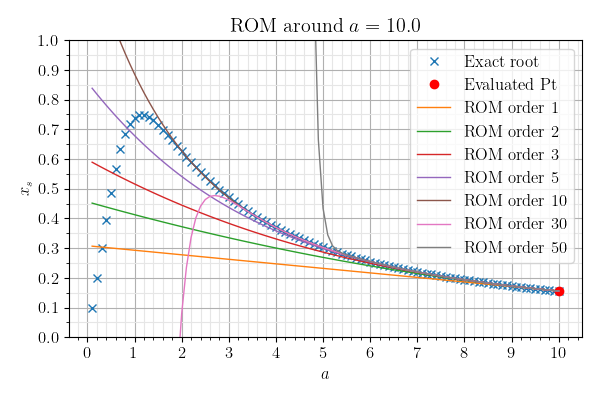

0
1
2
3
4
5
6


In [82]:
plt.figure(figsize=(6,4))
plt.plot(a_vec,x_vec,'xC0',lw=1.5,label = 'Exact root')
plt.plot(a.real,x.real[0,0],'or',lw=1.5,label = 'Evaluated Pt')
i = 0
orders_plt = orders[:]
for order in orders_plt:
    idx = orders.index(order)
    print(idx)
    plt.plot(a_vec,rom_vec[idx,:],'C'+str(i+1),lw=1.0,label='ROM order '+str(order))
    i+=1
# end for 
plt.axis([None,None,0,1.0])
plt.title("ROM around $a={0:.1f}$".format(a.real))
plt.xlabel("$a$")
plt.ylabel("$x_{s}$")
plt.grid()
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.1))
plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.2))
plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
plt.grid(which='minor',color=(0.9,0.9,0.9))
plt.legend()
plt.tight_layout()
plt.savefig('png/rom_cos_func_a'+str(int(a.real))+'.png',dpi=150)
plt.savefig('pdf/rom_cos_func_a'+str(int(a.real))+'.pdf',dpi=150)
plt.show()

<IPython.core.display.Javascript object>


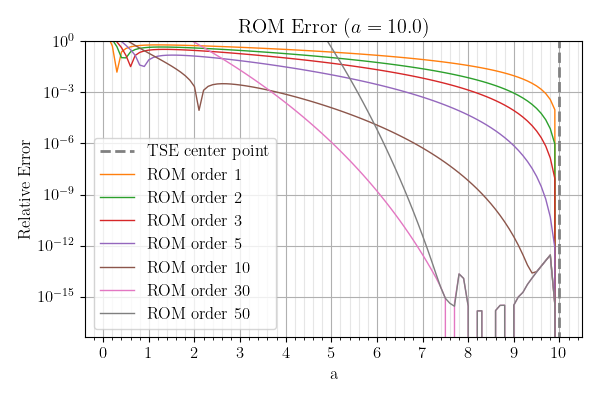

In [83]:
plt.figure(figsize=(6,4))
# plt.plot(a_vec,x_vec,'xC0',lw=1.5,label = 'Exact root')
i = 0
orders_plt = orders[:]
plt.semilogy([a.real,a.real],[0,1],'--',color='gray',lw=2.0,label='TSE center point')
for order in orders_plt:
    idx = orders.index(order)
    error = np.abs(rom_vec[idx,:] - x_vec)/np.abs(x_vec)
    plt.semilogy(a_vec,error,'C'+str(i+1),lw=1.0,label='ROM order '+str(order))

    i+=1
# end for 
plt.axis([None,None,None,1.0])
plt.title("ROM Error ($a={0:.1f}$)".format(a.real))
plt.xlabel("a")
plt.ylabel("Relative Error")
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
# plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.1))
plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.2))
# plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
plt.grid()
plt.grid(which='minor',color=(0.9,0.9,0.9))
plt.legend()
plt.tight_layout()

plt.savefig('png/err_rom_fun1_a'+str(int(a.real))+'.png',dpi=150)
plt.savefig('pdf/err_rom_fun1_a'+str(int(a.real))+'.pdf',dpi=150)
plt.show()

In [73]:
orders.index(50)

6

In [135]:
# ROM a = 5, ∆a = 3
anew = 2
Δa = anew - a.real
x.rom_eval([1],[Δa])

matso< shape: (1, 1), 
 - Column 0
(0,0) 0.601824
>

In [126]:
func(2.99067e+06,5)

matso< shape: (1, 1), 
 - Column 0
(0,0) -598135
>

In [12]:
order = 20
x0 = oti.array([1,1])
r  = np.sqrt(5)+oti.e(1, order = order)
m  = 3+oti.e(2, order = order)
b = -5+oti.e(3, order = order)

In [13]:
x = newton_otisis(fun2,j_oti,x0,1e-8, args = (r,m,b))

In [15]:
print(x.real)

[[2.]
 [1.]]


In [17]:
Δr = 0.1
Δm = 0.1
Δb = 0.1
m

3.0000 + 1.0000 * e([2])

In [18]:
rnew = r.rom_eval([1,2,3],[Δr,Δm,Δb])
mnew = m.rom_eval([1,2,3],[Δr,Δm,Δb])
bnew = b.rom_eval([1,2,3],[Δr,Δm,Δb])
xnew = x.rom_eval([1,2,3],[Δr,Δm,Δb])

In [18]:
x.real

array([[2.],
       [1.]])

In [19]:
x0[0,0]

1.0000

In [19]:
fun2(x,r,m,b).real

array([[8.88178420e-16],
       [6.66133815e-16]])

In [20]:
fun2(xnew,rnew,mnew,bnew)

matso< shape: (2, 1), 
 - Column 0
(0,0) -3.90799e-14
(1,0) -5.77316e-15
>

In [22]:
oti.print_capabilities()

 Order  Nbases    Ndir
     1   65000   65000
     2    1000  500500
     3     100  171700
     4     100 4421275
     5      10    2002
     6      10    5005
     7      10   11440
     8      10   24310
     9      10   48620
    10      10   92378
    11       5    1365
    12       5    1820
    13       5    2380
    14       5    3060
    15       5    3876
    16       5    4845
    17       5    5985
    18       5    7315
    19       5    8855
    20       5   10626
    21       3     253
    22       3     276
    23       3     300
    24       3     325
    25       3     351
    26       3     378
    27       3     406
    28       3     435
    29       3     465
    30       3     496
    31       3     528
    32       3     561
    33       3     595
    34       3     630
    35       3     666
    36       3     703
    37       3     741
    38       3     780
    39       3     820
    40       3     861
    41       3     903
    42       3     946
    43     